기초부터 시작하는 NLP: 문자-단위 RNN으로 이름 생성하기

출처 : https://tutorials.pytorch.kr/intermediate/char_rnn_generation_tutorial.html

이전 튜토리얼 : 이름 -> 언어
이번 튜토리얼 : 언어 -> 이름을 생성

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # EOS(end of sentence) 기호 추가

def findFiles(path): return glob.glob(path)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'Neal


In [2]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [3]:
import random

# 목록에서 무작위 아이템 반환
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# 임의의 category 및 그 category에서 무작위 줄(이름) 얻기
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

각 시간 단계 마다 (즉, 학습 단어의 각 문자 마다) 네트워크의 입력은 (언어, 현재 문자, 은닉 상태) 가 되고, 출력은 (다음 문자, 다음 은닉 상태) 가 된다. 따라서 각 학습 세트 마다 언어, 입력 문자의 세트, 출력/목표 문자의 세트가 필요하다.

각 시간 단계마다 현재 문자에서 다음 문자를 예측하기 때문에, 문자 쌍은 한 줄(하나의 이름)에서 연속된 문자 그룹입니다. - 예를 들어 "ABCD<EOS>" 는 (“A”, “B”), (“B”, “C”), (“C”, “D”), (“D”, “EOS”) 로 생성합니다.
    
Category(언어) Tensor는 <1 x n_categories> 크기의 One-hot Tensor 입니다. 학습시에 모든 시간 단계에서 네트워크에 이것을 전달합니다. - 이것은 설계 선택사항으로, 초기 은닉 상태 또는 또 다른 전략의 부분으로 포함될 수 있습니다.

In [4]:
# Category를 위한 One-hot 벡터
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# 입력을 위한 처음부터 마지막 문자(EOS 제외)까지의  One-hot 행렬
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# 목표를 위한 두번째 문자 부터 마지막(EOS) 까지의 LongTensor
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

학습 동안 편의를 위해 무작위로 (category[언어], line[이름])을 가져오고 그것을 필요한 형태 (category[언어], input[현재 문자], target[다음 문자]) Tensor로 바꾸는 randomTrainingExample 함수를 만들 예정입니다

In [5]:
# 임의의 Category에서 Category, Input, Target Tensor를 만듭니다.
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [6]:
# 분류의 경우 마지막 출력만 사용하지만, 생성에서는 모든 단계에서 예측을 수행, 모든 단계에서 loss를 계산 

criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [7]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [8]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # plot_every 마다 초기화

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 11s (5000 5%) 2.9602
0m 23s (10000 10%) 2.6251
0m 34s (15000 15%) 2.7796
0m 46s (20000 20%) 2.3798
0m 57s (25000 25%) 2.5289
1m 8s (30000 30%) 2.0862
1m 19s (35000 35%) 2.8379
1m 30s (40000 40%) 2.9154
1m 41s (45000 45%) 3.0495
1m 52s (50000 50%) 3.0086
2m 3s (55000 55%) 1.8988
2m 14s (60000 60%) 2.6856
2m 26s (65000 65%) 2.5785
2m 37s (70000 70%) 1.8034
2m 49s (75000 75%) 2.6191
3m 0s (80000 80%) 2.5126
3m 12s (85000 85%) 1.7339
3m 23s (90000 90%) 3.0843
3m 34s (95000 95%) 2.2973
3m 45s (100000 100%) 1.6661


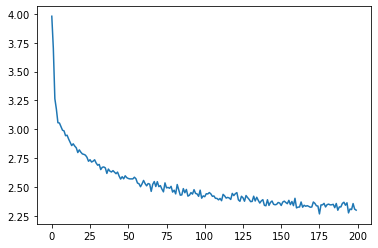

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [11]:
max_length = 20

# 카테고리와 시작 문자로 부터 샘플링 하기
def sample(category, start_letter='A'):
    with torch.no_grad():  # 샘플링에서 히스토리를 추적할 필요 없음
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# 하나의 카테고리와 여러 시작 문자들로 여러 개의 샘플 얻기
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

samples('Korean', 'KOR')

Rovers
Uarinov
Santon
Ganger
Erent
Ronger
Santa
Perra
Allana
Chan
Han
Iun
Kon
Ohon
Ro
